<a href="https://colab.research.google.com/github/kimdonggyun/SLR/blob/main/SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sea Level Rise Analysis**

In [ ]:
# install package
!pip install geopandas folium rasterio pykml shapely ipyleaflet ipywidgets ipympl

In [ ]:
# import libraries
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from osgeo import gdal
from pykml import parser
import geopandas as gpd
import folium
import fiona
from shapely.geometry import Polygon
from ipyleaflet import Map, GeoJSON, DrawControl
from ipywidgets import interact, interactive, fixed, interact_manual, Button, Output
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import imageio
import os

In [ ]:
# build functions and set variables
# 1. calculate height increase rate of mangroves
# apply gompertz growth model for the yearly height increase rate
def gompertz_height(t, a, b, c):
    """
    Gompertz growth model.
    Args:
        t: Time points.
        a: Maximum height.
        b: Growth rate parameter.
        c: Shape parameter.
    Returns:
        Predicted heights.
    """
    return a * np.exp(-b * np.exp(-c * t))

# calculate average sea level anomaly
# annual sea level anomaluy based on https://sealevel.nasa.gov/data-analysis-tool
anomaly_SL = np.linspace(0, 0.21, 6) # unit meter

# 2. calculate magnitude of risk on mangrove survival rate with regard to sea level rise
# survival rate calculation with regard to the sea level and tree height
def survival_rate(sea_level, tree_height):
  """
  Args:
    sea_level: sea level in meters
    tree_height: tree height in meters
  Returns:
    survival rate as rate 0-1 (1 is highest survival rate (100%)) and 0 is lowest survival rate (0%)
  """
  r = (tree_height - sea_level) / tree_height
  if r <0.2:
    rate = 0
  elif r<0.3 and r>=0.2:
    rate = 0.2
  elif r<0.4 and r>=0.3:
    rate = 0.3
  elif r<0.6 and r>=0.4:
    rate = 0.4
  elif r<0.8 and r>=0.6:
    rate = 0.6
  elif r<1.0 and r>=0.8:
    rate = 0.8
  elif r == 1.0:
    rate = 1
  elif r > 1.0:
    print("something wrong")
  return rate

# calculate erosion rate
def simulate_erosion(df, erosion_factor=0.5):
    """
    Simulate soil erosion and sediment redistribution based on sea level rise.
    This function applies the Bruun rule to simulate erosion and sediment redistribution,
    however, does not exactly follow the Bruun rule.
    The basic concept of Brunn rule is applied (i.e., Eroded soil near the shorline is distributed on the active profile).
    It depends on the project area where mangroves are planted, but the mangrove planting area does not cover most of the active coastal profile,
    certain ratio of eroded soil will be re-distributed on the project area having certain depth.

    Parameters:
    df (pd.DataFrame): DataFrame containing longitude, latitude, and depth columns.
    erosion_factor (float): Factor determining the extent of erosion (default is 0.1).

    Returns:
    pd.DataFrame: DataFrame with updated depth information after erosion and sediment redistribution.

    Bruun rule
    R: shorline recession in meters
    S: Sea level rise
    L: horizontal length of the bottom affected by the sea level rise in meters
    h: depth of closure in meters
    B: dune height above sea level in meters
    Beta: average slope of the active profile

    R = (S*L)/(h+B) = S/tan(Beta)
    """
    # 1. Identify grids where depth is between 0 and -0.5 (erosion zone)
    erosion_zone = df[(df['depth'] < 0) & (df['depth'] > -0.5)].copy()

    # 2. Calculate eroded volume for each grid in the erosion zone
    # Since grid area is 1m², volume calculation simplifies to depth * erosion_factor
    erosion_zone['eroded_volume'] = erosion_factor * erosion_zone['depth'].abs()

    # 3. Sum the total eroded volume
    total_eroded_volume = erosion_zone['eroded_volume'].sum()

    # 4. Distribute 50% of the total eroded volume to grids where depth is < 0 (deeper grids)
    deep_grids = df[df['depth'] < 0].copy()
    if not deep_grids.empty:
        volume_per_grid = (total_eroded_volume * 0.5) / len(deep_grids)
        df.loc[df['depth'] < 0, 'depth'] += volume_per_grid

    # 5. Update the depths in the erosion zone (erode the soil in the shallower grids)
    df.loc[(df['depth'] < 0) & (df['depth'] > -0.5), 'depth'] -= erosion_zone['eroded_volume']

    # Return the updated DataFrame
    return df

Bruun rule
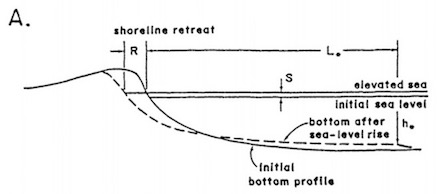

In [ ]:
# create plot of yearly height increase
a = 8  # Maximum height
b = 2.2  # Growth rate parameter
c = 0.08  # Shape parameter
t = np.arange(101)  # Time points from 0 to 100 years

height = gompertz_height(t, a, b, c)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(t, height, color='green')
plt.xlabel("Age (years)", size =12)
plt.ylabel("Height (meters)", size =12)
plt.title("Height Development", size =12)
plt.ylim(-0.5, 9)
plt.xlim(-3, 110)
plt.xticks(size =12)
plt.yticks(size =12)
plt.grid(True)

#save figure
plt.savefig('/content/drive/MyDrive/SLR/height_development.png')
plt.close()

1. Load Sea Level Rise Projections
data source: https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool

In [ ]:
# Load Excel file
file_path = '/content/drive/MyDrive/SLR/ipcc_ar6_sea_level_projection_10_104.xlsx'
xls = pd.ExcelFile(file_path)

# Extract information from Total Rates Sheet
total_df = pd.read_excel(xls, sheet_name='Total Rates')

In [ ]:
# Filter for chosen model and percentile
ssp_model = total_df[
    (total_df['scenario'] == 'ssp245') &
    (total_df['quantile'] == 50)
]

# select the years of interest
year_of_interest = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2110, 2120]
ssp_model_filtered = ssp_model[year_of_interest]
ssp_model_df = pd.DataFrame(columns=['year', 'sea_level'])
ssp_model_df['year'] = year_of_interest
ssp_model_df['sea_level'] = ssp_model_filtered.iloc[:, 0:].values[0]

2. Load KML file and plot each project area (polygon) in the map


In [ ]:
# Load the KML file
fiona.drvsupport.supported_drivers['KML'] = 'rw'
kml_file_path = '/content/drive/MyDrive/SLR/100ha.kml'  # Adjust the path to your KML file

# iterate through KML file
# create empty Geo Data Frame
gdf = gpd.GeoDataFrame()
# iterate over layers save the data on the Data Frame
for layer in fiona.listlayers(kml_file_path):
    # read layer into GeoDataFrame
    s = gpd.read_file(kml_file_path, driver='KML', layer=layer)
    s["Description"] = layer[0:]
    gdf = pd.concat([gdf, s], ignore_index=True)

# select certain data
gdf_sel = gdf.loc[gdf['Description']=="Kep", :]
# Create a Folium map centered on the first geometry in the GeoDataFrame
center = [gdf_sel.geometry.centroid.y.mean(), gdf_sel.geometry.centroid.x.mean()]
m = Map(center=center, zoom=10)

# Add the polygons to the map
geo_json = GeoJSON(data=gdf_sel.__geo_interface__)
m.add_layer(geo_json)

# Create a DrawControl to enable polygon selection and editing
draw_control = DrawControl()

# Function to handle feature selection and modification
def handle_draw(self, action, geo_json):
    if action == 'created' or action == 'edited':
        coords = geo_json['geometry']['coordinates']
        print(f"Selected Line Coordinates: {coords}")

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# Display the map
m

<ipython-input-80-20c3fd9983be>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf_sel.geometry.centroid.y.mean(), gdf_sel.geometry.centroid.x.mean()]


Map(center=[10.505674702834872, 104.31495709675323], controls=(ZoomControl(options=['position', 'zoom_in_text'…

3. Plot each project area (polygon) on a figure plot and select the nearest shorline

In [ ]:
# Function to plot polygon with vertices
def plot_polygon_with_vertices(geom):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = geom.exterior.xy
    scatter = ax.scatter(x, y, color='yellow', picker=True)  # Emphasize vertices with red points
    ax.plot(x, y, color='black', linewidth=0.7)  # Plot the polygon
    ax.set_title("Click on vertices to select")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.ticklabel_format(useOffset=False)
    return fig, ax, scatter, list(zip(x, y))

# adding grid cell with 1m^2
# https://www.dcceew.gov.au/themes/custom/awe/fullcam/Help-FullCAM2020/180_Latitude%20and%20Longitude.htm#:~:text=Length%20Approximations,-One%20degree%20of&text=One%20hundredth%20of%20a%20degree,degrees%20is%20about%20a%20metre).
def create_grid_in_polygon(polygon, cell_size=0.01): # 0.00001 degree equals to 1m. Except near the poles
    # Get the bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate the grid cells (1x1 meter squares)
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    grid_cells = []

    for x in x_coords:
        for y in y_coords:
            cell = Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
            if polygon.intersects(cell):
                grid_cells.append(cell)

    # Create a GeoDataFrame for the grid cells
    grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

    return grid_gdf

# Function to handle clicks
def on_click(event, vertices, ax, fig, clicked_vertices):
    if event.inaxes is not None and event.xdata is not None and event.ydata is not None:
        # Calculate distances from clicked point to all vertices
        distances = [np.sqrt((vertex[0] - event.xdata)**2 + (vertex[1] - event.ydata)**2) for vertex in vertices]

        # Find the closest vertex
        min_distance_index = np.argmin(distances)
        closest_vertex = vertices[min_distance_index]

        if closest_vertex not in clicked_vertices:
            clicked_vertices.append(closest_vertex)
            ax.scatter(*closest_vertex, color='Green', marker='x')  # Show selected vertices
            fig.canvas.draw_idle()  # Redraw the plot
            print(f"Clicked vertex: {closest_vertex}")

# Interactive function to handle vertex selection with button
def interactive_plot_with_button(gdf_row, grid_gdf, number):
    geom = gdf_row.geometry.iloc[number]  # Extract the individual geometry
    fig, ax, scatter, vertices = plot_polygon_with_vertices(geom)

    grid_gdf.boundary.plot(ax=ax, color='silver', linewidth=0.2) # add grid cell in 1 meter resolution

    clicked_vertices = []
    # Connect the click event to the on_click function
    fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, vertices, ax, fig, clicked_vertices))

    # Create a button widget
    button = Button(description="Finish Selection")
    output = Output()

    def on_button_click(b):
        with output:
            print("Selection complete!")
            print("Selected vertices:", clicked_vertices)
        plt.close(fig)  # Close the plot window

    button.on_click(on_button_click)

    # Display the button and plot
    display(button, output)
    plt.show()

    return clicked_vertices

Button(description='Finish Selection', style=ButtonStyle())

Output()

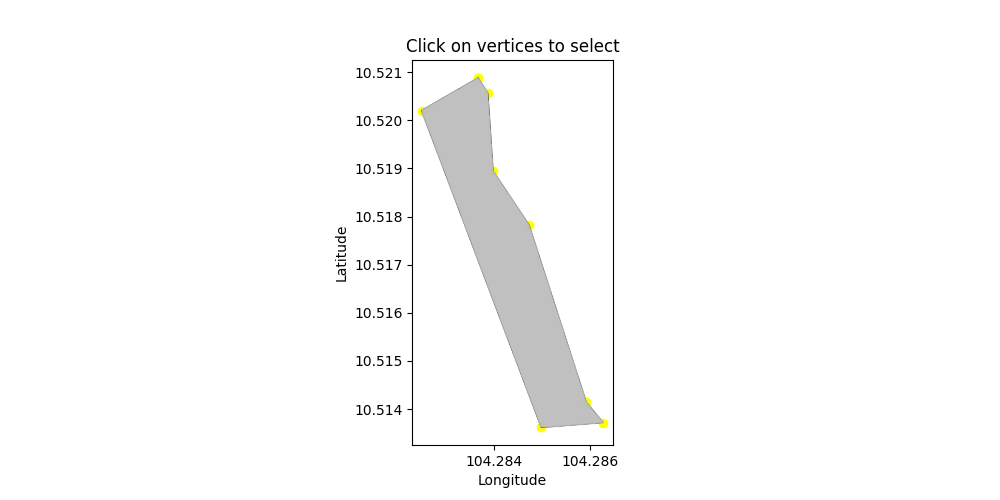

Selected vertices: []
Clicked vertex: (104.2836740239214, 10.520880220537)
Clicked vertex: (104.2838773721894, 10.52055812363259)
Clicked vertex: (104.2839855171938, 10.51894362051007)
Clicked vertex: (104.2847321182503, 10.51782390722166)
Clicked vertex: (104.2859208020383, 10.5141447426351)
Clicked vertex: (104.2862698765602, 10.51372061789205)


In [ ]:
# Example: Select vertices for the first polygon in the GeoDataFrame with button
# activate widget interaction
%matplotlib widget
number = 4 # sequence of project area (polygon)
polygon = gdf_sel.geometry.iloc[number]
area = gdf_sel.Name.iloc[number]
gdf_grid = create_grid_in_polygon(polygon, cell_size=0.00001) # 1m resolution
selected_vertices = interactive_plot_with_button(gdf_sel, gdf_grid, number)

print("Selected vertices:", selected_vertices)

In [ ]:
# assign depth on each grid point
# Convert to LineString in the same CRS
line = LineString([Point(x, y) for x, y in selected_vertices])

# Calculate distances from each grid point to the line
gdf_grid['distance_to_line'] = gdf_grid.geometry.apply(lambda point: point.distance(line))

# Calculate depth based on distance (linearly decreasing depth as distance increases)
slope = 1/100 #meter 2meter depth at 100m distance from the shorline without water
gdf_grid['depth'] = -(gdf_grid['distance_to_line']/0.00001) * slope

# apply soil erosion
gdf_grid = simulate_erosion(gdf_grid, erosion_factor=0.2)

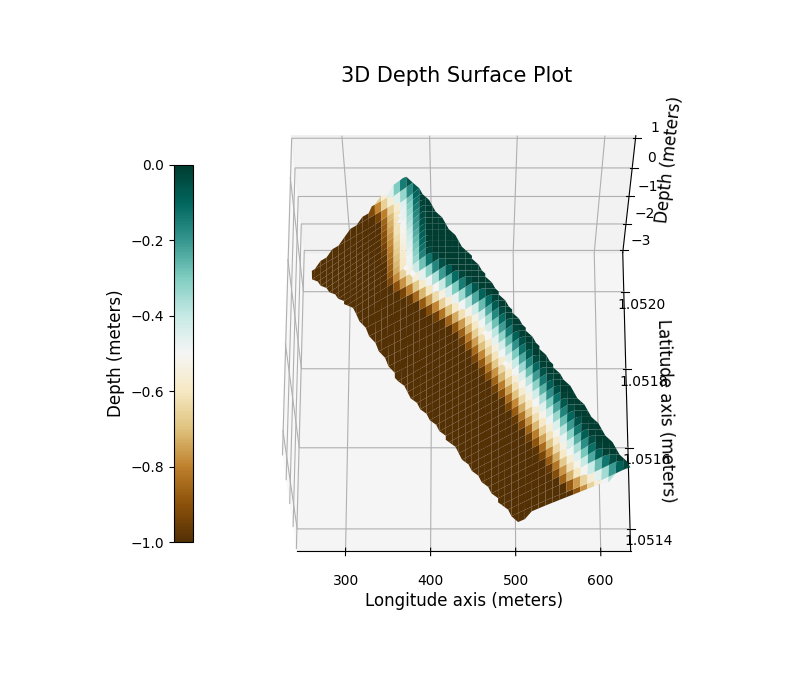

In [ ]:
# Convert to DataFrame for plotting
df_grid = pd.DataFrame({
    'longitude': [p.centroid.x for p in gdf_grid.geometry],
    'latitude': [p.centroid.y for p in gdf_grid.geometry],
    'depth': gdf_grid['depth']
})

# Define grid boundaries
x = df_grid['longitude']
y = df_grid['latitude']
z = df_grid['depth']

# Create grid for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((x, y), z, (xi, yi), method='linear')

# Plotting
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf= ax.plot_surface(xi/0.00001, yi/0.00001, zi, cmap='BrBG', edgecolor='none')
surf.set_clim(-1, 0)

# Add color bar which maps values to colors
cbar = fig.colorbar(surf, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
cbar.set_label('Depth (meters)', fontsize=12)

# Labels and Title
ax.set_xlabel('Longitude axis (meters)', fontsize=12)
ax.set_ylabel('Latitude axis (meters)', fontsize=12)
ax.set_zlabel('Depth (meters)', fontsize=12)
ax.set_title('3D Depth Surface Plot', fontsize=15)
ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
ax.set_zlim(-3, 1)

# Control the number of axis-ticks
ax.zaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# Forcefully remove any stray scientific notation
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.view_init(elev=65, azim=-90) #set the view
plt.show()

# save figure
plt.savefig('/content/drive/MyDrive/SLR/depth_surface.png', dpi=300)

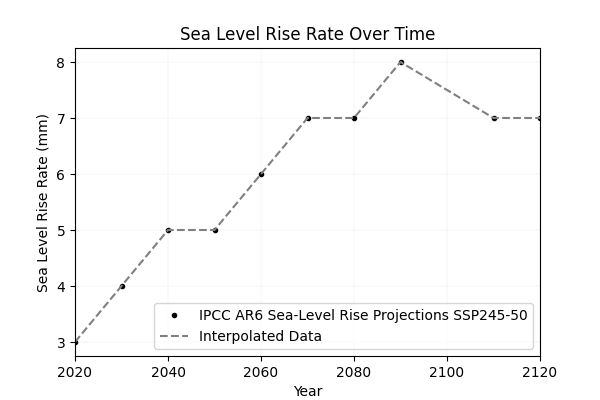

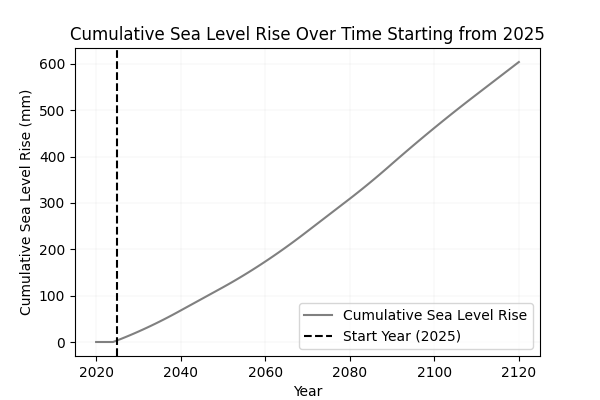

In [ ]:
# calculate the sea level rise scenario each year
years = np.arange(2020, 2121)

# Interpolate sea level rise values
SLR_interpolated_values = np.interp(years, ssp_model_df['year'], ssp_model_df['sea_level'])

# Create a DataFrame for interpolated Sea Level Rise Rate
SLR_interpolated_df = pd.DataFrame({
    'year': years,
    'sea_level_Interpolated': SLR_interpolated_values
})

# Create a DataFrame for interpolated cumulative Sea Level Rise
cumulative_sea_level_rise = np.zeros_like(SLR_interpolated_values)  # Initialize with zeros
start_year_index = np.where(years == 2025)[0][0]

# Calculate cumulative sea level rise
cumulative_sea_level_rise[start_year_index:] = np.cumsum(SLR_interpolated_values[start_year_index:])

# Create a DataFrame for the cumulative data
SLR_cumulative_interpolated_df = pd.DataFrame({
    'year': years,
    'sea_level_cumulative_interpolated': cumulative_sea_level_rise
})

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(ssp_model_df['year'], ssp_model_df['sea_level'], '.', label='IPCC AR6 Sea-Level Rise Projections SSP245-50', color="black")
plt.plot(SLR_interpolated_df['year'], SLR_interpolated_df['sea_level_Interpolated'], '--', label='Interpolated Data', color="gray")
plt.xlabel('Year')
plt.ylabel('Sea Level Rise Rate (mm)')
plt.xlim(2020, 2120)
plt.title('Sea Level Rise Rate Over Time')
plt.legend()
plt.grid(True, linewidth=0.1, color='silver')
plt.savefig('/content/drive/MyDrive/SLR/sea_level_rise_rate.png', dpi=300)
plt.show()

# Plotting
plt.figure(figsize=(6,4))
plt.plot(SLR_cumulative_interpolated_df['year'], SLR_cumulative_interpolated_df['sea_level_cumulative_interpolated'], '-', label='Cumulative Sea Level Rise', color="gray")
plt.xlabel('Year')
plt.ylabel('Cumulative Sea Level Rise (mm)')
plt.title('Cumulative Sea Level Rise Over Time Starting from 2025')
plt.axvline(x=2025, color='black', linestyle='--', label='Start Year (2025)')
plt.legend()
plt.grid(True, linewidth=0.1, color='silver')
plt.savefig('/content/drive/MyDrive/SLR/sea_level_rise_cumulative.png', dpi=300)
plt.show()

In [ ]:
# calulate the risk of sea level rise

#SLR_cumulative_interpolated_df
#df_grid
#height = gompertz_height(t, a, b, c)
#print(SLR_cumulative_interpolated_df)
#print(df_grid)
#survival_rate(sea_level, tree_height)
tree_height_df = pd.DataFrame(columns=['year', 'tree_height'])
tree_height_df['year'] = np.arange(2025, 2126)
tree_height_df['tree_height'] = height

tree_height_SLR = pd.merge(SLR_cumulative_interpolated_df, tree_height_df, on='year') # merge tree height and sea level rise dataframe by year

df_grid_scenario = df_grid.copy()
# calculate the survival rate based on the sea level and tree height
for index_ts, row_ts in tree_height_SLR.iterrows():
  sea_level = row_ts['sea_level_cumulative_interpolated'] # in mili meters
  tree_height = row_ts['tree_height'] # in meters
  year = int(row_ts['year'])
  for index_d, row_d in df_grid_scenario.iterrows():
    depth = row_d['depth'] # in meters
    survival_rate_value = survival_rate((sea_level/1000)-depth, tree_height)
    df_grid_scenario.at[index_d, 'survival_rate_'+str(year)] = survival_rate_value

something wrong


UnboundLocalError: local variable 'rate' referenced before assignment

In [ ]:
#save df_grid_scenario as csv file
df_grid_scenario.to_csv('/content/drive/MyDrive/SLR/df_grid_scenario.csv', index=False)

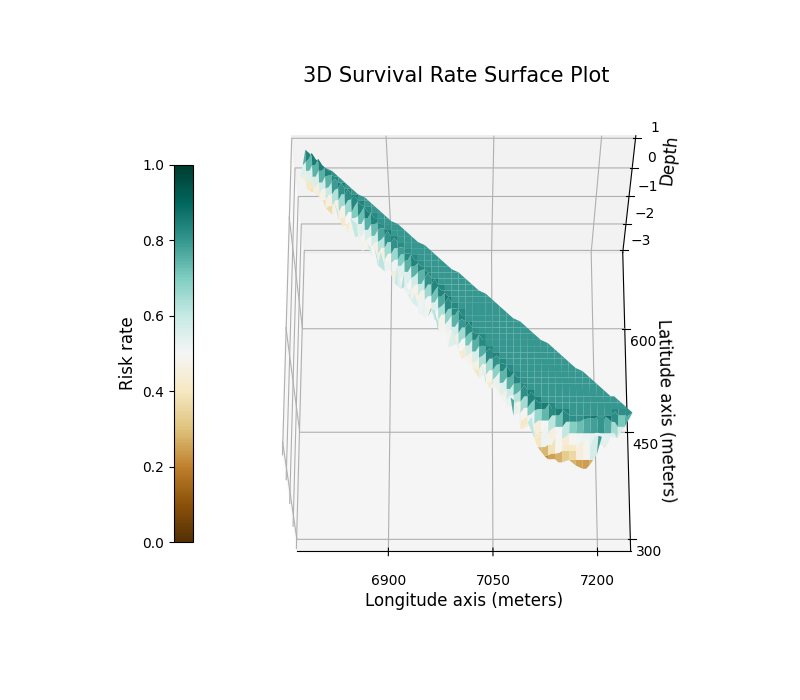

In [ ]:
# plot in 3d. Longitude as x value, latitude as y value, depth as z value and survival rate as color bar
# Create a 3D plot, Use grid boundaries, grid interpolation longitude and latitude data from above codes (x, y) (xi, yi)
z_risk = df_grid_scenario['survival_rate_2026']
zi_risk = griddata((x, y), z_risk, (xi, yi), method='linear')

# Plotting
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting
surf_risk = ax.plot_surface(xi/0.00001, yi/0.00001, zi_risk, cmap='BrBG', edgecolor='none')
surf_risk.set_clim(0, 1)

# Adding color bar which maps values to colors
cbar = fig.colorbar(surf_risk, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
cbar.set_label('Risk rate', fontsize=12)  # Set label and its size

# Labels and Title
ax.set_xlabel('Longitude axis (meters)', fontsize=12)
ax.set_ylabel('Latitude axis (meters)', fontsize=12)
ax.set_zlabel('Depth', fontsize=12)
ax.set_title('3D Survival Rate Surface Plot', fontsize=15)
ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
ax.set_zlim(-3, 1)

# Control the number of axis-ticks
ax.zaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# Forcefully remove any stray scientific notation
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.view_init(elev=65, azim=-90) #set the view

# Show the plot
plt.show()

In [ ]:

# Ensure the output directory exists
output_dir = "/content/drive/MyDrive/SLR/animation_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List to store the file paths of generated frames
frames = []

# Iterate over each year from 2025 to 2120
for year in range(2025, 2121):
    # Extract the survival rate data for the current year
    z_risk = df_grid_scenario[f'survival_rate_{year}']
    zi_risk = griddata((x, y), z_risk, (xi, yi), method='linear')

    # Plotting
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the surface
    surf_risk = ax.plot_surface(xi/0.00001, yi/0.00001, zi_risk, cmap='BrBG', edgecolor='none')
    surf_risk.set_clim(0, 1)

    # Adding color bar which maps values to colors
    cbar = fig.colorbar(surf_risk, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
    cbar.set_label('Risk rate', fontsize=12)  # Set label and its size

    # Labels and Title
    ax.set_xlabel('Longitude axis (meters)', fontsize=12)
    ax.set_ylabel('Latitude axis (meters)', fontsize=12)
    ax.set_zlabel('Depth', fontsize=12)
    ax.set_title(f'3D Survival Rate Surface Plot - Year {year}', fontsize=15)
    ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
    ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
    ax.set_zlim(-3, 1)

    # Control the number of axis-ticks
    ax.zaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # Forcefully remove any stray scientific notation
    ax.xaxis.get_offset_text().set_visible(False)
    ax.yaxis.get_offset_text().set_visible(False)

    ax.view_init(elev=65, azim=-90) #set the view

    # Save the frame
    frame_path = os.path.join(output_dir, f'frame_{year}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)

    # Clear the plot to avoid overlap in the next iteration
    plt.close(fig)

# Create a GIF from the saved frames
with imageio.get_writer('survival_rate_animation.gif', mode='I', duration=0.5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Optionally, remove the frame files
#for frame in frames:
#    os.remove(frame)

print("Animation saved as 'survival_rate_animation_soil.gif'")

<ipython-input-41-bc0af99838d0>:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


Animation saved as 'survival_rate_animation_soil.gif'
